<a href="https://colab.research.google.com/github/narendrapatel6321-dotcom/Customer_Segmentation/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation using RFM Analysis


**Goal:** Segment customers using Recency, Frequency, and Monetary (RFM) analysis
to identify meaningful customer groups for business action.


In [1]:

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns


## Load Data

In [2]:

df = pd.read_csv("OnlineRetail.csv", encoding="ISO-8859-1")
df.head()


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,6,01/12/2010 08:26,2.55,17850.0
1,536365,71053,6,01/12/2010 08:26,3.39,17850.0
2,536365,84406B,8,01/12/2010 08:26,2.75,17850.0
3,536365,84029G,6,01/12/2010 08:26,3.39,17850.0
4,536365,84029E,6,01/12/2010 08:26,3.39,17850.0


## Basic Cleaning

In [3]:

# Drop missing customer IDs
df = df.dropna(subset=["CustomerID"])

# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"],format = '%d/%m/%Y %H:%M')

df = df[df["UnitPrice"] > 0]

# Total price (keep negative quantities for cancellation correction)
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]



## RFM Feature Engineering

In [4]:

reference_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby("CustomerID")
    .agg({
        "InvoiceDate": lambda x: (reference_date - x.max()).days,
        "InvoiceNo": "nunique",
        "TotalPrice": "sum"
    })
    .reset_index()
)

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]
rfm = rfm[rfm["Monetary"] > 0]
rfm.head()


,CustomerID,Recency,Frequency,Monetary
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40
5,12352.0,36,11,1545.41


## Log Transformation & Scaling

In [5]:
rfm[["Recency", "Frequency", "Monetary"]].skew()


,0
Recency,1.267138
Frequency,11.346091
Monetary,21.600605


Frequency and Monetary show strong right skew, confirming the presence of long-tailed customer behavior.
Log transformation is applied to reduce dominance of extreme values and improve distance-based clustering stability.

In [6]:

rfm_log = rfm.copy()
rfm_log["Frequency"] = np.log1p(rfm_log["Frequency"])
rfm_log["Monetary"] = np.log1p(rfm_log["Monetary"])
rfm_log["Recency"] = 1/(rfm_log["Recency"])

scaler = StandardScaler()
X = scaler.fit_transform(rfm_log[["Recency", "Frequency", "Monetary"]])


## Elbow & Silhouette Analysis

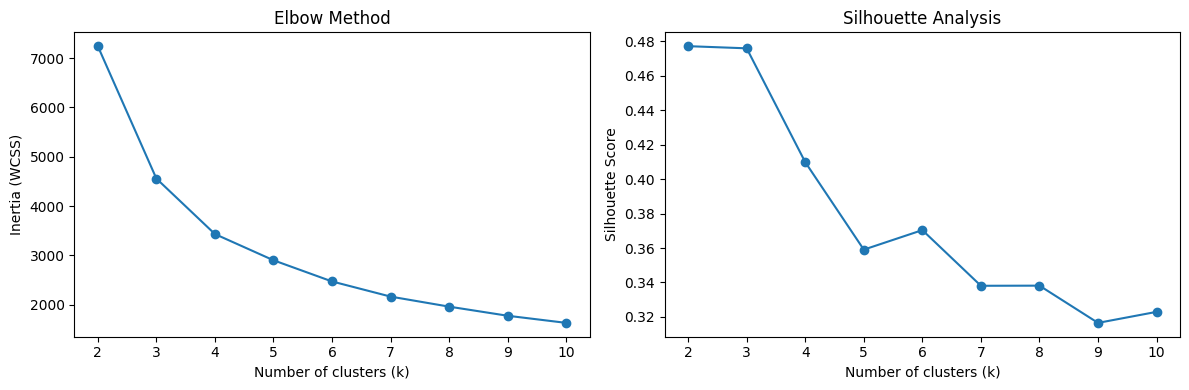

In [7]:

inertia = []
silhouette_scores = []

K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=108, n_init=10)
    labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Elbow curve
axes[0].plot(K, inertia, marker='o')
axes[0].set_xlabel("Number of clusters (k)")
axes[0].set_ylabel("Inertia (WCSS)")
axes[0].set_title("Elbow Method")

# Silhouette score
axes[1].plot(K, silhouette_scores, marker='o')
axes[1].set_xlabel("Number of clusters (k)")
axes[1].set_ylabel("Silhouette Score")
axes[1].set_title("Silhouette Analysis")

plt.tight_layout()
plt.show()



## Final Clustering

In [8]:

kmeans = KMeans(n_clusters=4, random_state=108, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(X)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,Cluster
1,12347.0,2,7,4310.00,3
2,12348.0,75,4,1797.24,0
3,12349.0,19,1,1757.55,0
4,12350.0,310,1,334.40,1
5,12352.0,36,11,1545.41,3


## Cluster Profiling

In [9]:

cluster_summary = (
    rfm.groupby("Cluster")
    .agg({
        "Recency": "mean",
        "Frequency": "mean",
        "Monetary": "mean",
        "CustomerID": "count"
    })
    .rename(columns={"CustomerID": "CustomerCount"})
)

cluster_summary


,Recency,Frequency,Monetary,CustomerCount
Cluster,,,,
0,63.127633,4.345725,1345.246247,1614
1,139.540718,1.460293,310.434512,1977
2,1.000000,21.847619,10096.498286,105
3,20.127796,15.833866,7137.709521,626


## Visualization

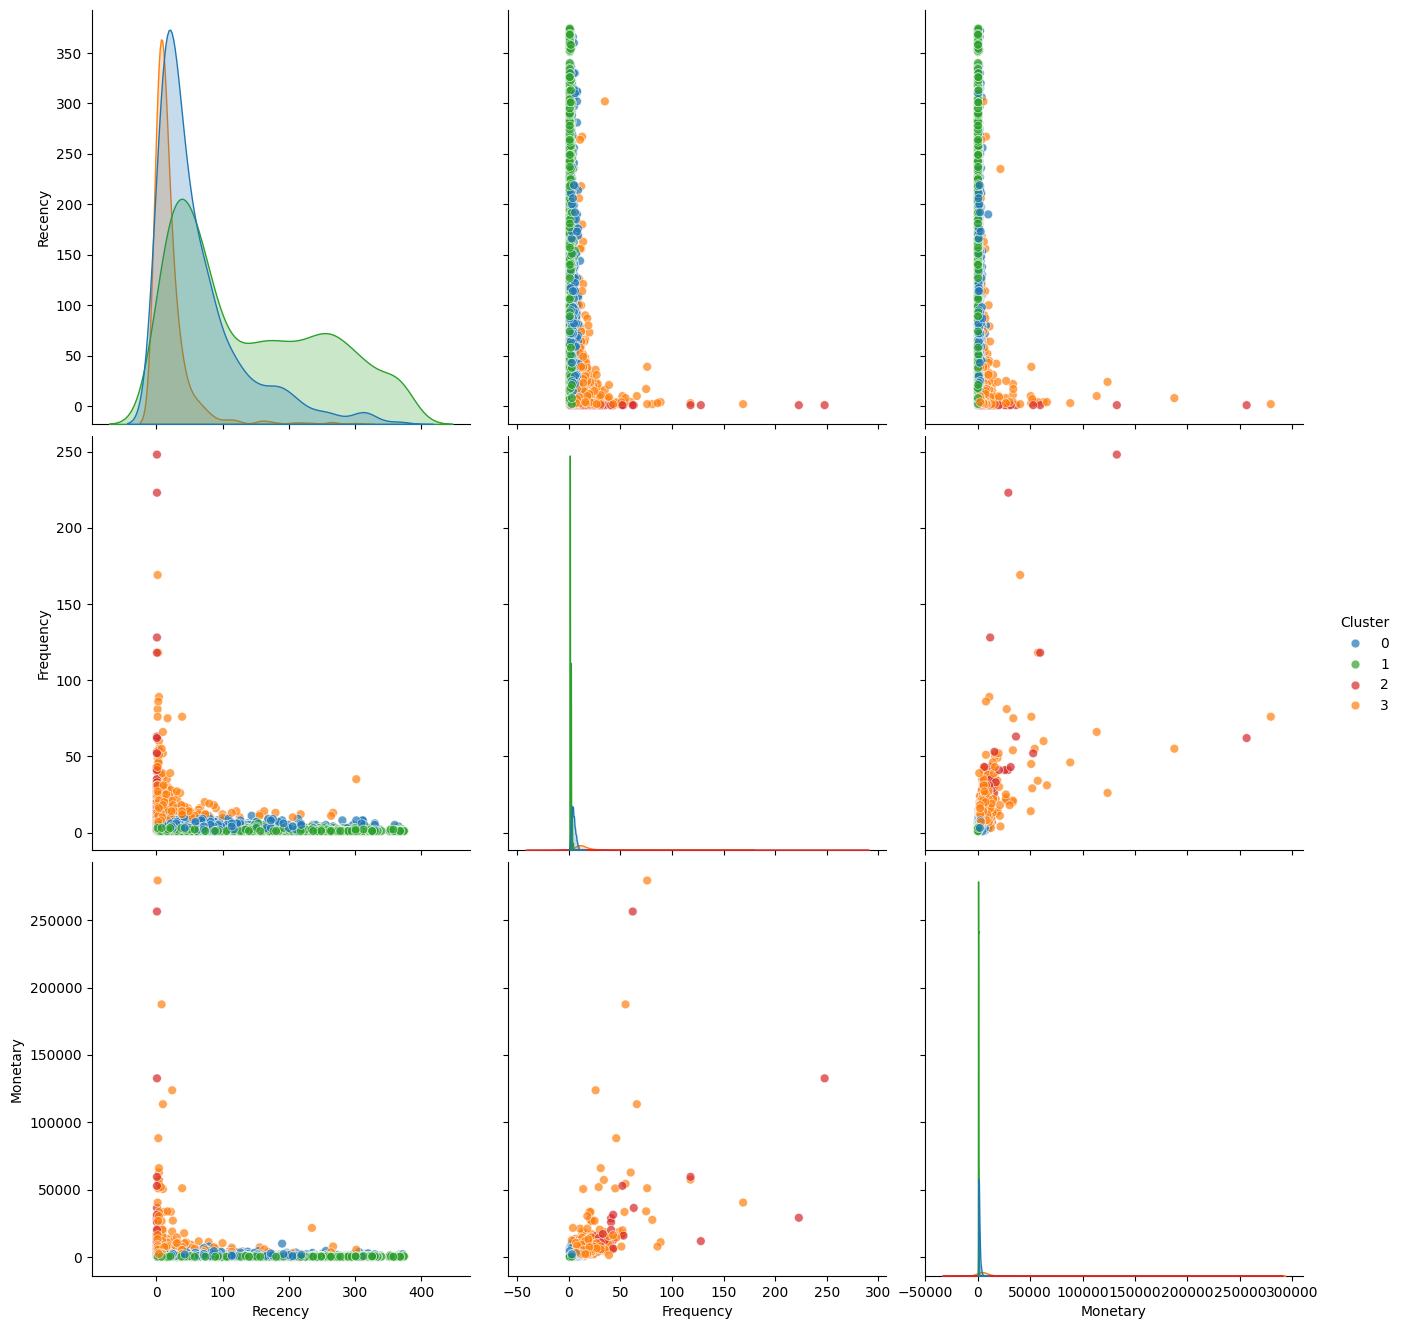

In [10]:
palette = {
    0: "#1f77b4",  # blue
    1: "#2ca02c",  # green
    2: "#d62728",  # red
    3: "#ff7f0e"   # orange
}

sns.pairplot(
    rfm,
    hue="Cluster",
    vars=["Recency", "Frequency", "Monetary"],
    palette=palette,
    height=4.5,
    plot_kws={"alpha": 0.7, "s": 40}
)

plt.show()
